In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time
from IPython.display import display

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.54MB/s]


In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
import torchsummary

# # Create some generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

torchsummary.summary(netG, input_size=(nz,1,1))
torchsummary.summary(netD, input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

In [ ]:
import torch.nn.functional as F

# === Inception Score ===
def inception_score(model, images, splits=10):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(images), 256):
            batch = images[i:i+256].to(next(model.parameters()).device)
            out = F.softmax(model(batch), dim=1)
            preds.append(out)

    preds = torch.cat(preds, dim=0)
    split_scores = []
    for chunk in preds.chunk(splits):
        py = chunk.mean(0, keepdim=True)
        kl = chunk * (torch.log(chunk + 1e-8) - torch.log(py + 1e-8))
        split_scores.append(torch.exp(kl.sum(1).mean()))
    return float(torch.stack(split_scores).mean())


In [ ]:
# === Unified evaluation using only Inception Score ===
def evaluate_scores(model, gen_images, print_scores=False, return_scores=True):
    is_score = inception_score(model, gen_images)

    if print_scores:
        print(f"Inception Score: \t{is_score:.4f}")
    if return_scores:
        return is_score


In [ ]:
# === Model evaluation on generated digits ===
def evaluate_model(gen_model, eval_model, train_loader, return_scores=False, pr = True):
    gen_model.eval()
    all_fake = []

    with torch.no_grad():
        for real_batch in train_loader:
            real_images = real_batch[0].to(device)
            z = torch.randn(real_images.size(0), nz, 1, 1, device=device)
            fake_images = gen_model(z)
            all_fake.append(fake_images)

    fake_eval = torch.cat(all_fake, dim=0)

    score = evaluate_scores(eval_model, fake_eval, print_scores=pr, return_scores=return_scores)

    gen_model.train()
    return score if return_scores else None


In [ ]:
from tqdm import tqdm

def train_lenet_feature_extractor(train_loader, num_epochs=10, lr=1e-3):
    class LeNetFeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
            self.pool = nn.AvgPool2d(2)
            self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
            self.fc1 = nn.Linear(16 * 4 * 4, 120)
            self.fc2 = nn.Linear(120, 84)
            self.classifier = nn.Linear(84, 10)

        def forward(self, x, return_features=False):
            x = F.relu(self.conv1(x))
            x = self.pool(x)
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            features = F.relu(self.fc2(x))
            if return_features:
                return features
            else:
                return self.classifier(features)

    model = LeNetFeatureExtractor().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(num_epochs), desc="Training LeNet"):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            correct += outputs.argmax(1).eq(labels).sum().item()
            total += labels.size(0)

    acc = 100. * correct / total
    print(f"\n✅ LeNet Final Accuracy: {acc:.2f}%")
    return model


In [ ]:
model_mnist_lenet = train_lenet_feature_extractor(train_loader)

Training LeNet: 100%|██████████| 10/10 [02:07<00:00, 12.76s/it]


✅ LeNet Final Accuracy: 99.24%


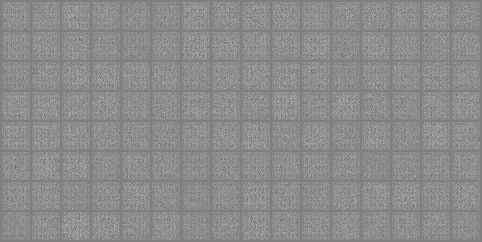

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

In [ ]:
def gradient_penalty(D,x,y):
    ###
    b = x.shape[0]
    if y.shape[0]!=b:
        print('wrong size')
    alpha = torch.rand((b,1,1,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    return torch.mean((gradients_norm - 1)**2)

[1/20] Loss_D: -38.2535, Loss_G: 93.6984
[2/20] Loss_D: -46.5891, Loss_G: -3.4998
[3/20] Loss_D: -39.3090, Loss_G: 42.0776
[4/20] Loss_D: -11.3051, Loss_G: -29.4031
[5/20] Loss_D: -30.0392, Loss_G: 68.6911
[6/20] Loss_D: -12.7440, Loss_G: 65.5089
[7/20] Loss_D: 14.5360, Loss_G: 50.2324
[8/20] Loss_D: -10.5378, Loss_G: 15.0664
[9/20] Loss_D: -12.8396, Loss_G: 112.2520
[10/20] Loss_D: -9.1966, Loss_G: -29.1850
[11/20] Loss_D: -5.6169, Loss_G: 62.1066
[12/20] Loss_D: -22.6670, Loss_G: 14.1496
[13/20] Loss_D: -4.1846, Loss_G: 63.6985
[14/20] Loss_D: -15.8251, Loss_G: 108.6527
[15/20] Loss_D: 9.9682, Loss_G: 119.0930
[16/20] Loss_D: -10.8470, Loss_G: 186.6449
[17/20] Loss_D: -12.4806, Loss_G: 104.6089
[18/20] Loss_D: 4.0079, Loss_G: 109.0501
[19/20] Loss_D: -17.5236, Loss_G: 109.2354
[20/20] Loss_D: -5.1729, Loss_G: 134.7667
Inception Score: 	8.7311
⏱️ Training completed in 888.00 seconds.


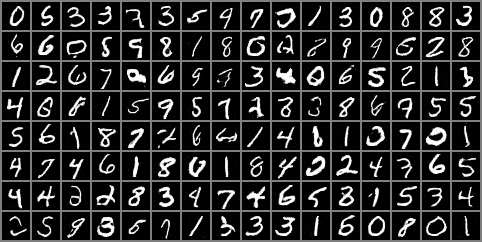

In [ ]:

import time

# Training loop (printing only)
n_epochs = 20
lr = 2*1e-4
lambda_gp = 0.1

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


G_losses = []

start_time = time.time()

for epoch in range(n_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        z = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G(z)
        D_real = D(real_images)
        D_fake = D(fake_images.detach())
        gp = gradient_penalty(D, real_images.data, fake_images.data)
        D_loss = -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gp

        optimizerD.zero_grad()
        D_loss.backward()
        optimizerD.step()

        z = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G(z)
        G_loss = -torch.mean(D(fake_images))

        optimizerG.zero_grad()
        G_loss.backward()
        optimizerG.step()

        G_losses.append(G_loss.item())
    print(f"[{epoch+1}/{n_epochs}] Loss_D: {D_loss.item():.4f}, Loss_G: {G_loss.item():.4f}")

end_time = time.time()
final_is_score = evaluate_model(G, model_mnist_lenet, train_loader, return_scores = True)
print(f"⏱️ Training completed in {end_time - start_time:.2f} seconds.")
show(G)

In [ ]:
# Evaluation-only training loop to plot Inception Score progression
G_eval = Generator().to(device)
D_eval = Discriminator().to(device)
G_eval.apply(weights_init)
D_eval.apply(weights_init)

optimizerD_eval = optim.Adam(D_eval.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG_eval = optim.Adam(G_eval.parameters(), lr=lr, betas=(0.5, 0.999))

G_scores = []
scores_every = 200
n_it = 0

print("⚙️ Running IS tracking training loop")

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    for i, (real_images, _) in enumerate(train_loader):
        n_it += 1
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Discriminator update
        z = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G_eval(z)
        D_real = D_eval(real_images)
        D_fake = D_eval(fake_images.detach())
        gp = gradient_penalty(D_eval, real_images.data, fake_images.data)
        D_loss = -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gp

        optimizerD_eval.zero_grad()
        D_loss.backward()
        optimizerD_eval.step()

        # Generator update
        z = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G_eval(z)
        G_loss = -torch.mean(D_eval(fake_images))

        optimizerG_eval.zero_grad()
        G_loss.backward()
        optimizerG_eval.step()

        # Save IS score periodically
        if n_it % scores_every == 0:
            is_score = evaluate_model(G_eval, model_mnist_lenet, train_loader, return_scores=True, pr=False)
            G_scores.append(is_score)

    print(f"[Eval Epoch {epoch+1}/{n_epochs}] Loss_D: {D_loss.item():.4f}, Loss_G: {G_loss.item():.4f}")

print("✅ Inception score tracking complete.")


⚙️ Running IS tracking training loop
Epoch 1/20
[Eval Epoch 1/20] Loss_D: -40.6087, Loss_G: 54.0668
Epoch 2/20
[Eval Epoch 2/20] Loss_D: -19.2261, Loss_G: -0.2330
Epoch 3/20
[Eval Epoch 3/20] Loss_D: -2.9214, Loss_G: 18.6258
Epoch 4/20
[Eval Epoch 4/20] Loss_D: -53.5402, Loss_G: 86.1938
Epoch 5/20
[Eval Epoch 5/20] Loss_D: -26.1890, Loss_G: 127.8073
Epoch 6/20
[Eval Epoch 6/20] Loss_D: -13.8316, Loss_G: 83.1978
Epoch 7/20
[Eval Epoch 7/20] Loss_D: -9.6095, Loss_G: -19.3063
Epoch 8/20
[Eval Epoch 8/20] Loss_D: -20.9108, Loss_G: 21.8098
Epoch 9/20
[Eval Epoch 9/20] Loss_D: -15.8694, Loss_G: 39.7217
Epoch 10/20
[Eval Epoch 10/20] Loss_D: -9.3486, Loss_G: 3.7718
Epoch 11/20
[Eval Epoch 11/20] Loss_D: 3.6233, Loss_G: 22.6977
Epoch 12/20
[Eval Epoch 12/20] Loss_D: -15.8644, Loss_G: 13.8431
Epoch 13/20
[Eval Epoch 13/20] Loss_D: -21.2499, Loss_G: 48.4112
Epoch 14/20
[Eval Epoch 14/20] Loss_D: -8.9337, Loss_G: 96.9615
Epoch 15/20
[Eval Epoch 15/20] Loss_D: -2.1669, Loss_G: 40.2096
Epoch 16/20


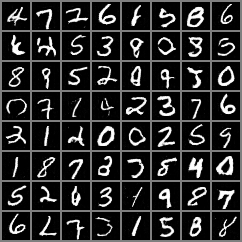

In [ ]:
import matplotlib.pyplot as plt
import torch
import zipfile
import numpy as np

# Save generator model
torch.save(G.state_dict(), "mnist_generator.pth")

# Save final Inception Score
with open("mnist_final_is.txt", "w") as f:
    f.write(f"{final_is_score:.6f}")

# Save loss curve
plt.figure(dpi=100)
plt.plot(G_losses, label='Generator Loss')
plt.title("Generator Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("mnist_gloss_curve.png")
plt.close()

# Save Inception Score curve
plt.figure(dpi=100)
plt.plot(G_scores, label='Inception Score')
plt.title("Inception Score Curve")
plt.xlabel(f"Iterations (x{scores_every})")
plt.ylabel("IS Score")
plt.legend()
plt.savefig("mnist_is_curve.png")
plt.close()

# Save raw data arrays for later comparison
np.save("mnist_g_losses.npy", np.array(G_losses))
np.save("mnist_is_scores.npy", np.array(G_scores))

# Save sample image grid
z = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    samples = G(z).detach().cpu()
sample_grid = torchvision.utils.make_grid(samples, nrow=8)
imshow(sample_grid)
torchvision.utils.save_image(sample_grid, "mnist_samples.png")

# Save training time
with open("mnist_training_time.txt", "w") as f:
    f.write(f"Training time: {end_time - start_time:.2f} seconds")

# Zip everything
with zipfile.ZipFile("mnist_wgan_output.zip", "w") as zipf:
    zipf.write("mnist_generator.pth")
    zipf.write("mnist_gloss_curve.png")
    zipf.write("mnist_is_curve.png")
    zipf.write("mnist_samples.png")
    zipf.write("mnist_training_time.txt")
    zipf.write("mnist_final_is.txt")
    zipf.write("mnist_g_losses.npy")
    zipf.write("mnist_is_scores.npy")

# Download the zip file
